<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
from tensorflow import keras
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

%load_ext tensorboard
import datetime
import IPython
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [136]:
hoje = datetime.date.today()
diaSemana = hoje.weekday()
hoje = str(hoje)

In [137]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-03-21_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-03-21_TEMPHIST.csv'),sep=";",decimal=",")

In [138]:
print(historicoCarga.shape)
print(historicoTemperatura.shape)

(45740, 6)
(45720, 6)


In [139]:
def basePreprocessing(carga,temperatura):
    dataset = carga.merge(temperatura)
    dataset = dataset.drop(["Min"], axis = 1 )
    dataset = dataset.rename({'Ano': 'Year', 'Mes': 'Month',"Dia":"Day","Hora":"Hour"}, axis=1)
    dataset["Date"] = pd.to_datetime(dataset[["Year","Month","Day","Hour"]])
    dataset["Weekday"] = dataset["Date"].dt.dayofweek

    dataset["Carga_Var"] = dataset["Carga"].pct_change()
    dataset["Temp_Var"] = dataset["Temperatura"].pct_change()

    day = 24*60*60
    week = (7)*day
    year = (365.2425)*day
    
    timestamp_s = dataset["Date"].map(datetime.datetime.timestamp)
    
    dataset['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    dataset['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

    dataset['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
    dataset['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

    dataset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    dataset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return dataset, timestamp_s

In [140]:
historico, timestamp = basePreprocessing(historicoCarga,historicoTemperatura)

cols = [  
    'Date',
    'Day sin',
    'Day cos',
    'Week sin',
    'Week cos',
    'Year sin',
    'Year cos',
    'Carga',
    'Temperatura',
    ]

historico = historico[cols]
base = historico.values
historico

,Date,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos,Carga,Temperatura
0,2016-01-01 01:00:00,2.588190e-01,0.965926,0.804598,0.593820,-0.001950,0.999998,32420.1640,25.393000
1,2016-01-01 02:00:00,5.000000e-01,0.866025,0.826239,0.563320,-0.001233,0.999999,32259.2245,25.062000
2,2016-01-01 03:00:00,7.071068e-01,0.707107,0.846724,0.532032,-0.000516,1.000000,31836.5975,24.733000
3,2016-01-01 04:00:00,8.660254e-01,0.500000,0.866025,0.500000,0.000201,1.000000,31241.3815,24.635000
4,2016-01-01 05:00:00,9.659258e-01,0.258819,0.884115,0.467269,0.000917,1.000000,30706.5625,24.139999
...,...,...,...,...,...,...,...,...,...
45547,2021-03-12 20:00:00,-8.660254e-01,0.500000,0.997204,-0.074730,0.942292,0.334793,47875.6305,25.780000
45548,2021-03-12 21:00:00,-7.071068e-01,0.707107,0.993712,-0.111964,0.942531,0.334117,47306.1600,24.604000
45549,2021-03-12 22:00:00,-5.000000e-01,0.866025,0.988831,-0.149042,0.942771,0.333442,46542.8500,24.169000
45550,2021-03-12 23:00:00,-2.588190e-01,0.965926,0.982566,-0.185912,0.943009,0.332766,44860.6870,23.980000


# Explorando Dataset

In [ ]:
plot_cols = ['Carga', 'Temperatura']
plot_features = historico[plot_cols]
plot_features.index = historico["Date"]
_ = plot_features.plot(subplots=True)

plot_features = historico[plot_cols][25:48]
plot_features.index = historico["Date"][25:48]
_ = plot_features.plot(subplots=True)

In [ ]:
plt.plot(np.array(historico['Day sin'])[:24*7])
plt.plot(np.array(historico['Day cos'])[:24*7])

plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0, 0.5, 'Temperatura [°C]')

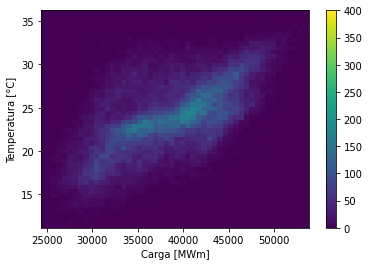

In [10]:
plt.hist2d(historico['Carga'], historico['Temperatura'], bins=(50, 50), vmax=400)

plt.colorbar()
plt.xlabel('Carga [MWm]')
plt.ylabel('Temperatura [°C]')

In [ ]:
fft = tf.signal.rfft(historico['Carga'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(historico['Carga'])

hours_per_year = 24*365.2524

years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))

plt.xscale('log')
plt.ylim(0, 10e7)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1,52, 365.2524], labels=['1/Year',"1/week", '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Preparando Dados

In [141]:
Xdataset = historico[[
    'Day sin',
    'Day cos',
    'Week sin',
    'Week cos',
    'Year sin',
    'Year cos',
    'Carga',
    'Temperatura',]]

column_indices = {name: i for i, name in enumerate(Xdataset.columns)}

n = len(historico)

dias= 30

print(f'Tamanho original da base X = {Xdataset.shape}')

x_train = Xdataset[0:int(n*0.80)]

x_valid = Xdataset[int(n*0.80):int(n*0.90)]

x_test = Xdataset[int(n*0.90):]

num_features = historico.shape[1]

print(f'    formato dados de treino X = {x_train.shape}')
print(f'    formato dados de validação X = {x_valid.shape}')
print(f'    formato dados de teste X = {x_test.shape}')

Tamanho original da base X = (45552, 8)
    formato dados de treino X = (36441, 8)
    formato dados de validação X = (4555, 8)
    formato dados de teste X = (4556, 8)


In [142]:
train_mean = x_train.mean()
train_std = x_train.std()

x_train = (x_train - train_mean) / train_std
x_valid = (x_valid - train_mean) / train_std
x_test = (x_test - train_mean) / train_std

In [143]:
train_mean

Day sin            0.000188
Day cos            0.000050
Week sin          -0.000241
Week cos          -0.000327
Year sin           0.017125
Year cos           0.031994
Carga          38642.856993
Temperatura       24.110692
dtype: float64

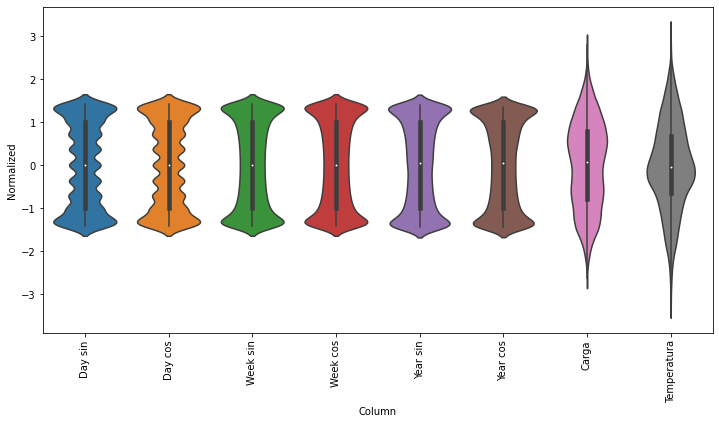

In [144]:
df_std = (Xdataset - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(Xdataset.keys(), rotation=90)

In [145]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = x_train, val_df=x_valid , test_df=x_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [146]:
standard_window = WindowGenerator(input_width=168, label_width=168, shift=24,
                     label_columns=['Carga'])

In [147]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [148]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(x_train[:standard_window.total_window_size]),
                           np.array(x_train[100:100+standard_window.total_window_size]),
                           np.array(x_train[200:200+standard_window.total_window_size])])


example_inputs, example_labels = standard_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 192, 8)
Inputs shape: (3, 168, 8)
labels shape: (3, 168, 1)


In [149]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(x_test[:standard_window.total_window_size]),
                           np.array(x_test[100:100+standard_window.total_window_size]),
                           np.array(x_test[200:200+standard_window.total_window_size])])


example_inputs, example_labels = standard_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 192, 8)
Inputs shape: (3, 168, 8)
labels shape: (3, 168, 1)


In [150]:
standard_window.example = example_inputs, example_labels

In [151]:
def plot(self, model=None, plot_col='Carga', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Carga')

WindowGenerator.plot = plot

In [152]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [153]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [157]:
for example_inputs, example_labels in standard_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 168, 8)
Labels shape (batch, time, features): (32, 168, 1)


In [169]:
def last_timestep_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1],Y_pred[:,-1])

In [159]:
MAX_EPOCHS = 100

val_performance = {}
performance = {}

def compile_and_fit(model, window, patience = 5):
  
    es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 5, verbose = 1)
    rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 2, verbose = 1)
    mcp = ModelCheckpoint(filepath=f"pesos-{datetime.date.today()}.h5", monitor = "loss", save_best_only = True, verbose=1)
  
    model.compile(
        optimizer = tf.optimizers.Adam(learning_rate=0.01), 
        loss = tf.losses.MeanSquaredError(), 
        metrics = [last_timestep_mse])
  
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[es,rlr,mcp])
    return history

In [ ]:
lstm_model = Sequential([
    LSTM(units = 128, return_sequences = True, input_shape = [None, 8], dropout=0.2 , recurrent_dropout=0.2),
    LSTM(units = 128, return_sequences = True, dropout=0.2 , recurrent_dropout=0.2),
    TimeDistributed(Dense(units = 24)) 
])
lstm_model.summary()

In [160]:
print('Input shape:', standard_window.example[0].shape)
print('Output shape:', lstm_model(standard_window.example[0]).shape)

Input shape: (32, 168, 8)
Output shape: (32, 168, 24)


In [ ]:
history = compile_and_fit(lstm_model, standard_window)

IPython.display.clear_output()

from google.colab import files
files.download(f"pesos-{datetime.date.today()}.h5")

In [163]:
val_performance = {}
performance = {}

In [ ]:
lstm_model = load_model("/content/drive/MyDrive/TG/MODELOS/pesos-2021-03-21 (C).h5", custom_objects={"last_timestep_mse":last_timestep_mse})
lstm_model.summary()

In [ ]:
performance['LSTM'] = lstm_model.evaluate(standard_window.test, verbose = 0)

In [196]:
predictions = lstm_model.predict(standard_window.test)